In [99]:
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd
import pymongo
import gridfs
import mimetypes

# Example Particle tracking on video stored in MongoDB gridfs

from a jupyter terminal run command

` mongod --dbpath=data/db `

This will start a mongodb server in the container, in the next cell we connect to the database

In [2]:
# connect to the database
conn=pymongo.MongoClient()
grid_fs = gridfs.GridFS(conn.microrheology)  

The database is initally empty so we upload 

In [71]:
#the example data file is a video of brownian motion of 400nm tracers in water acquired with a phantom camera (.cin) 
#the video and additional metadata can be stored in the same mongodb gridfs object


filename_orig='400nm_100dil_water_01umpix_100fps_short.cin' #filename in the filesystem
interval=0.01 #time between frames in seconds        
filename_indb=filename_orig # filename in the database

operator='Marco'
calibration=0.1 #mu per pixel
tracer_radius=0.2E-6 #tracer radius in meter
temperature=25 #Celsius

info={'interval':interval,
      'filename' : filename_orig,
      'muperpix':0.1,
      'tracer_radius': tracer_radius,
      'temperature': 25,
      'operator':'Marco'
     }

#Opening and Storing the .cin file to the Database and appending the info dictionary to it
with open('400nm_100dil_water_01umpix_100fps_short.cin','rb') as file:
    grid_fs.put(file,filename=filename_indb,info=info)

In [72]:
#List files present in the database
grid_fs.list()

['400nm_100dil_water_01umpix_100fps_short.cin']

In [73]:
video=grid_fs.get_last_version('400nm_100dil_water_01umpix_100fps_short.cin')

In [74]:
video.info

{'interval': 0.01,
 'filename': '400nm_100dil_water_01umpix_100fps_short.cin',
 'muperpix': 0.1,
 'tracer_radius': 2e-07,
 'temperature': 25,
 'operator': 'Marco'}

In [75]:
# in case you want to delete the file from the DB
# remember if you upload multiple files with the same filename it will handle them as multiple versions
#grid_fs.delete(grid_fs.get_last_version('400nm_100dil_water_01umpix_100fps_short.cin')._id)

The video object returned by pymongo is a gridfs.grid_file.GridOut and is a filelike object so with a small modification to the cine function can be passed instead of the filename

    def __init__(self, filename, process_func=None,
                 dtype=None, as_grey=False):

        if type(video)==gridfs.grid_file.GridOut:
            self.f=filename
        else:
            self.f = open(filename, 'rb')

In [76]:
###############################################################################

# Reader for CINE files produced by Vision Research Phantom Software
# Author: Dustin Kleckner
# dkleckner@uchicago.edu

# Modified by Marco Caggioni (marco.caggioni@gmail.com)
# Modified by Thomas A Caswell (tcaswell@uchicago.edu)
# Added to PIMS by Thomas A Caswell (tcaswell@gmail.com)
###############################################################################
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import six

from pims.frame import Frame
from pims.base_frames import FramesSequence
import time
import struct
import numpy as np
from numpy import array, frombuffer
from threading import Lock
import datetime
import hashlib

__all__ = ('Cine', )


FRACTION_MASK = (2**32-1)
MAX_INT = 2**32

BYTE = 'B'
WORD = 'H'
INT16 = 'h'
SHORT = 'h'
BOOL = 'i'
DWORD = 'I'
UINT = 'I'
LONG = 'l'
INT = 'l'
FLOAT = 'f'
DOUBLE = 'd'
TIME64 = 'Q'
RECT = '4i'
WBGAIN = '2f'
IMFILTER = '28i'

CFA_NONE = 0
CFA_VRI = 1
CFA_VRIV6 = 2
CFA_BAYER = 3
CFA_BAYERFLIP = 4

TAGGED_FIELDS = {
    1000: ('ang_dig_sigs', ''),
    1001: ('image_time_total', TIME64),
    1002: ('image_time_only', TIME64),
    1003: ('exposure_only', DWORD),
    1004: ('range_data', ''),
    1005: ('binsig', ''),
    1006: ('anasig', ''),
    # 1007 exists in my files, but is not in documentation I can find
    1007: ('undocumented', '')}

HEADER_FIELDS = [
    ('type', '2s'),
    ('header_size', WORD),
    ('compression', WORD),
    ('version', WORD),
    ('first_movie_image', LONG),
    ('total_image_count', DWORD),
    ('first_image_no', LONG),
    ('image_count', DWORD),
    ('off_image_header', DWORD),
    ('off_setup', DWORD),
    ('off_image_offsets', DWORD),
    ('trigger_time', TIME64),
]

BITMAP_INFO_FIELDS = [
    ('bi_size', DWORD),
    ('bi_width', LONG),
    ('bi_height', LONG),
    ('bi_planes', WORD),
    ('bi_bit_count', WORD),
    ('bi_compression', DWORD),
    ('bi_image_size', DWORD),
    ('bi_x_pels_per_meter', LONG),
    ('bi_y_pels_per_meter', LONG),
    ('bi_clr_used', DWORD),
    ('bi_clr_important', DWORD),
]

SETUP_FIELDS = [
    ('frame_rate_16', WORD),
    ('shutter_16', WORD),
    ('post_trigger_16', WORD),
    ('frame_delay_16', WORD),
    ('aspect_ratio', WORD),
    ('contrast_16', WORD),
    ('bright_16', WORD),
    ('rotate_16', BYTE),
    ('time_annotation', BYTE),
    ('trig_cine', BYTE),
    ('trig_frame', BYTE),
    ('shutter_on', BYTE),
    # Guessed at length... because it isn't documented!  This seems to work.
    ('description_old', '121s'),
    ('mark', '2s'),
    ('length', WORD),
    ('binning', WORD),
    ('sig_option', WORD),
    ('bin_channels', SHORT),
    ('samples_per_image', BYTE)] + \
    [('bin_name%d' % i, '11s') for i in range(8)] + [
        ('ana_option', WORD),
        ('ana_channels', SHORT),
        ('res_6', BYTE),
        ('ana_board', BYTE)] + \
    [('ch_option%d' % i, SHORT) for i in range(8)] + \
    [('ana_gain%d' % i, FLOAT) for i in range(8)] + \
    [('ana_unit%d' % i, '6s') for i in range(8)] + \
    [('ana_name%d' % i, '11s') for i in range(8)] + [
    ('i_first_image', LONG),
    ('dw_image_count', DWORD),
    ('n_q_factor', SHORT),
    ('w_cine_file_type', WORD)] + \
    [('sz_cine_path%d' % i, '65s') for i in range(4)] + [
    ('b_mains_freq', WORD),
    ('b_time_code', BYTE),
    ('b_priority', BYTE),
    ('w_leap_sec_dy', DOUBLE),
    ('d_delay_tc', DOUBLE),
    ('d_delay_pps', DOUBLE),
    ('gen_bits', WORD),
    ('res_1', INT16),  # Manual says INT, but this is clearly wrong!
    ('res_2', INT16),
    ('res_3', INT16),
    ('im_width', WORD),
    ('im_height', WORD),
    ('edr_shutter_16', WORD),
    ('serial', UINT),
    ('saturation', INT),
    ('res_5', BYTE),
    ('auto_exposure', UINT),
    ('b_flip_h', BOOL),
    ('b_flip_v', BOOL),
    ('grid', UINT),
    ('frame_rate', UINT),
    ('shutter', UINT),
    ('edr_shutter', UINT),
    ('post_trigger', UINT),
    ('frame_delay', UINT),
    ('b_enable_color', BOOL),
    ('camera_version', UINT),
    ('firmware_version', UINT),
    ('software_version', UINT),
    ('recording_time_zone', INT),
    ('cfa', UINT),
    ('bright', INT),
    ('contrast', INT),
    ('gamma', INT),
    ('reserved1', UINT),
    ('auto_exp_level', UINT),
    ('auto_exp_speed', UINT),
    ('auto_exp_rect', RECT),
    ('wb_gain', '8f'),
    ('rotate', INT),
    ('wb_view', WBGAIN),
    ('real_bpp', UINT),
    ('conv_8_min', UINT),
    ('conv_8_max', UINT),
    ('filter_code', INT),
    ('filter_param', INT),
    ('uf', IMFILTER),
    ('black_cal_sver', UINT),
    ('white_cal_sver', UINT),
    ('gray_cal_sver', UINT),
    ('b_stamp_time', BOOL),
    ('sound_dest', UINT),
    ('frp_steps', UINT),
    ] + [('frp_img_nr%d' % i, INT) for i in range(16)] + \
        [('frp_rate%d' % i, UINT) for i in range(16)] + \
        [('frp_exp%d' % i, UINT) for i in range(16)] + [
    ('mc_cnt', INT),
    ] + [('mc_percent%d' % i, FLOAT) for i in range(64)] + [
    ('ci_calib', UINT),
    ('calib_width', UINT),
    ('calib_height', UINT),
    ('calib_rate', UINT),
    ('calib_exp', UINT),
    ('calib_edr', UINT),
    ('calib_temp', UINT),
    ] + [('header_serial%d' % i, UINT) for i in range(4)] + [
    ('range_code', UINT),
    ('range_size', UINT),
    ('decimation', UINT),
    ('master_serial', UINT),
    ('sensor', UINT),
    ('shutter_ns', UINT),
    ('edr_shutter_ns', UINT),
    ('frame_delay_ns', UINT),
    ('im_pos_xacq', UINT),
    ('im_pos_yacq', UINT),
    ('im_width_acq', UINT),
    ('im_height_acq', UINT),
    ('description', '4096s')
]


class Cine(FramesSequence):
    """Read cine files

    Read cine files, the out put from Vision Research high-speed phantom
    cameras.  Support uncompressed monochrome and color files.

    Nominally thread-safe, but this assertion is not tested.


    Parameters
    ----------
    filename : string
        Path to cine file.
    process_func : function, optional
        callable with signalture `proc_img = process_func(img)`,
        which will be applied to the data from each frame
    dtype : numpy datatype, optional
        Image arrays will be converted to this datatype.
    as_grey : boolean, optional
        Convert color images to greyscale. False by default.
        May not be used in conjection with process_func.
    """
    @classmethod
    def class_exts(cls):
        return {'cine'} | super(Cine,
                                cls).class_exts()

    def __init__(self, filename, process_func=None,
                 dtype=None, as_grey=False):
        
        if type(video)==gridfs.grid_file.GridOut:
            self.f=filename
        else:
            self.f = open(filename, 'rb')
        
        self._filename = filename

        self.header_dict = self.read_header(HEADER_FIELDS)
        self.bitmapinfo_dict = self.read_header(BITMAP_INFO_FIELDS,
                                                self.off_image_header)
        self.setup_fields_dict = self.read_header(SETUP_FIELDS, self.off_setup)
        self.image_locations = self.unpack('%dQ' % self.image_count,
                                           self.off_image_offsets)
        if type(self.image_locations) not in (list, tuple):
            self.image_locations = [self.image_locations]

        self._width = self.bitmapinfo_dict['bi_width']
        self._height = self.bitmapinfo_dict['bi_height']
        self._pixel_count = self._width * self._height

        # Allows Cine object to be accessed from multiple threads!
        self.file_lock = Lock()

        self._hash = None

        # validate gray/process func
        self._validate_process_func(process_func)
        self._as_grey(as_grey, process_func)

        self._im_sz = (self._width, self._height)

        # sort out the data type by reading the meta-data
        if self.bitmapinfo_dict['bi_bit_count'] in (8, 24):
            self._data_type = 'u1'
        else:
            self._data_type = 'u2'

        # sort out what type to return data as
        if dtype is None:
            self._dtype = np.dtype(self._data_type)
        else:
            self._dtype = dtype
        self.tagged_blocks = self.read_tagged_blocks()
        self.frame_time_stamps = self.tagged_blocks['image_time_only']
        self.all_exposures = self.tagged_blocks['exposure_only']
        self.stack_meta_data = dict()
        self.stack_meta_data.update(self.bitmapinfo_dict)
        self.stack_meta_data.update({k: self.setup_fields_dict[k]
                                     for k in set(('trig_frame',
                                                   'gamma',
                                                   'frame_rate',
                                                   'shutter_ns'
                                                   )
                                                   )
                                                   })
        self.stack_meta_data.update({k: self.header_dict[k]
                                     for k in set(('first_image_no',
                                                   'image_count',
                                                   'total_image_count',
                                                   'first_movie_image'
                                                   )
                                                   )
                                                   })
        self.stack_meta_data['trigger_time'] = self.trigger_time

    @property
    def filename(self):
        return self._filename

    @property
    def frame_rate(self):
        return self.setup_fields_dict['frame_rate']

    # use properties for things that should not be changeable
    @property
    def cfa(self):
        return self.setup_fields_dict['cfa']

    @property
    def compression(self):
        return self.header_dict['compression']

    @property
    def pixel_type(self):
        return self._dtype

    @property
    def off_set(self):
        return self.header_dict['offset']

    @property
    def setup_length(self):
        return self.setup_fields_dict['length']

    @property
    def off_image_offsets(self):
        return self.header_dict['off_image_offsets']

    @property
    def off_image_header(self):
        return self.header_dict['off_image_header']

    @property
    def off_setup(self):
        return self.header_dict['off_setup']

    @property
    def image_count(self):
        return self.header_dict['image_count']

    @property
    def frame_shape(self):
        return self._im_sz

    def get_frame(self, j):
        md = dict()
        md['exposure'] = self.all_exposures[j]
        ts, sec_frac = self.frame_time_stamps[j]
        md['frame_time'] = {'datetime': ts,
                            'second_fraction': sec_frac}
        return Frame(self.process_func(self._get_frame(j)),
                     frame_no=j, metadata=md)

    def unpack(self, fs, offset=None):
        if offset is not None:
            self.f.seek(offset)
        s = struct.Struct('<' + fs)
        vals = s.unpack(self.f.read(s.size))
        if len(vals) == 1:
            return vals[0]
        else:
            return vals

    def read_tagged_blocks(self):
        '''
        Reads the tagged block meta-data from the header
        '''
        tmp_dict = dict()
        if not self.off_setup + self.setup_length < self.off_image_offsets:
            return
        next_tag_exists = True
        next_tag_offset = 0
        while next_tag_exists:
            block_size, next_tag_exists = self._read_tag_block(next_tag_offset,
                                                               tmp_dict)
            next_tag_offset += block_size
        return tmp_dict

    def _read_tag_block(self, off_set, accum_dict):
        '''
        Internal helper-function for reading the tagged blocks.
        '''
        with FileLocker(self.file_lock):
            self.f.seek(self.off_setup + self.setup_length + off_set)
            block_size = self.unpack(DWORD)
            b_type = self.unpack(WORD)
            more_tags = self.unpack(WORD)

            if b_type == 1004:
                # docs say to ignore range data it seems to be a poison flag,
                # if see this, give up tag parsing
                return block_size, 0

            try:
                d_name, d_type = TAGGED_FIELDS[b_type]

            except KeyError:
                return block_size, more_tags

            if d_type == '':
                # print "can't deal with  <" + d_name + "> tagged data"
                return block_size, more_tags

            s_tmp = struct.Struct('<' + d_type)
            if (block_size-8) % s_tmp.size != 0:
                #            print 'something is wrong with your data types'
                return block_size, more_tags

            d_count = (block_size-8)//(s_tmp.size)

            data = self.unpack('%d' % d_count + d_type)
            if not isinstance(data, tuple):
                # fix up data due to design choice in self.unpack
                data = (data, )

            # parse time
            if b_type == 1002 or b_type == 1001:
                data = [(datetime.datetime.fromtimestamp(d >> 32),
                         (FRACTION_MASK & d)/MAX_INT) for d in data]
            # convert exposure to seconds
            if b_type == 1003:
                data = [d/(MAX_INT) for d in data]

            accum_dict[d_name] = data

        return block_size, more_tags

    def read_header(self, fields, offset=0):
        self.f.seek(offset)
        tmp = dict()
        for name, format in fields:
            val = self.unpack(format)
            tmp[name] = val

        return tmp

    def _get_frame(self, number):
        with FileLocker(self.file_lock):
            # get basic information about the frame we want
            image_start = self.image_locations[number]
            annotation_size = self.unpack(DWORD, image_start)
            # this is not used, but is needed to advance the point in the file
            annotation = self.unpack('%db' % (annotation_size - 8))
            image_size = self.unpack(DWORD)

            cfa = self.cfa
            compression = self.compression

            # sort out data type looking at the cached version
            data_type = self._data_type

            # actual bit per pixel
            actual_bits = image_size * 8 // (self._pixel_count)

            # so this seem wrong as 10 or 12 bits won't fit in 'u1'
            # but I (TAC) may not understand and don't have a packed file
            # (which the docs seem to imply don't exist) to test on so
            # I am leaving it.  good luck.
            if actual_bits in (10, 12):
                data_type = 'u1'

            # move the file to the right point in the file
            self.f.seek(image_start + annotation_size)

            # suck the data out of the file and shove into linear
            # numpy array
            frame = frombuffer(self.f.read(image_size), data_type)

            # if mono-camera
            if cfa == CFA_NONE:
                if compression != 0:
                    raise ValueError("Can not deal with compressed files\n" +
                                     "compression level: " +
                                     "{}".format(compression))
                # we are working with a monochrome camera
                # un-pack packed data
                if (actual_bits == 10):
                    frame = _ten2sixteen(frame)
                elif (actual_bits == 12):
                    frame = _twelve2sixteen(frame)
                elif (actual_bits % 8):
                    raise ValueError('Data should be byte aligned, ' +
                         'or 10 or 12 bit packed (appears to be' +
                        ' %dbits/pixel?!)' % actual_bits)

                # re-shape to an array
                # flip the rows
                # and the cast to proper type
                frame = frame.reshape(self._height,
                                      self._width)[::-1].astype(self._dtype)

                if actual_bits in (10, 12):
                    frame = frame[::-1, :]
                    # Don't know why it works this way, but it does...
            # else, some sort of color layout
            else:
                if compression == 0:
                    # and re-order so color is RGB (naively saves as BGR)
                    frame = frame.reshape(self._height,
                                          self._width,
                                          3)[::-1, :, ::-1].astype(self._dtype)
                elif compression == 2:
                    raise ValueError("Can not process un-interpolated movies")
                else:
                    raise ValueError("Should never hit this, " +
                                     "you have an un-documented file\n" +
                                     "compression level: " +
                                     "{}".format(compression))

        return frame

    def __len__(self):
        return self.image_count

    len = __len__

    def get_time(self, i):
        '''Returm the time of frame i in seconds.'''
        return float(i) / self.frame_rate

    def get_fps(self):
        return self.frame_rate

    def close(self):
        self.f.close()

    def __unicode__(self):
        return self.filename

    def __str__(self):
        return unicode(self).encode('utf-8')

    def __repr__(self):
        # May be overwritten by subclasses
        return """<Frames>
Source: {filename}
Length: {count} frames
Frame Shape: {w} x {h}
Pixel Datatype: {dtype}""".format(w=self.frame_shape[0],
                                  h=self.frame_shape[1],
                                  count=len(self),
                                  filename=self.filename,
                                  dtype=self.pixel_type)

    @property
    def trigger_time(self):
        '''Returns the time of the trigger, tuple of (datatime_object,
        fraction_in_ns)'''
        trigger_time = self.header_dict['trigger_time']
        ts, sf = (datetime.datetime.fromtimestamp(trigger_time >> 32),
                   float(FRACTION_MASK & trigger_time)/(MAX_INT))

        return {'datetime': ts, 'second_fraction': sf}

    @property
    def hash(self):
        if self._hash is None:
            self._hash_fun()
        return self._hash

    def __hash__(self):
        return int(self.hash, base=16)

    def _hash_fun(self):
        """
        generates the md5 hash of the header of the file.  Here the
        header is defined as everything before the first image starts.

        This includes all of the meta-data (including the plethora of
        time stamps) so this will be unique.
        """
        # get the file lock (so we don't screw up any other reads)
        with FileLocker(self.file_lock):

            self.f.seek(0)
            max_loc = self.image_locations[0]
            md5 = hashlib.md5()

            chunk_size = 128*md5.block_size
            chunk_count = (max_loc//chunk_size) + 1

            for j in range(chunk_count):
                md5.update(self.f.read(128*md5.block_size))

            self._hash = md5.hexdigest()

    def __eq__(self, other):
        return self.hash == other.hash

    def __ne__(self, other):
        return not self == other


class FileLocker(object):
    """
    A context manager to lock and un-lock a the cine file

    See http://docs.python.org/2/library/contextlib.html
    http://docs.python.org/2/library/stdtypes.html#typecontextmanager
    http://docs.python.org/2/reference/datamodel.html#context-managers
    """
    def __init__(self, lock):
        self.lock = lock

    def __enter__(self):
        self.lock.acquire()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.lock.release()
        return False


# Should be divisible by 3, 4 and 5!  This seems to be near-optimal.
CHUNK_SIZE = 6 * 10 ** 5


def _ten2sixteen(a):
    """
    Convert array of 10bit uints to array of 16bit uints
    """
    b = np.zeros(a.size//5*4, dtype='u2')

    for j in range(0, len(a), CHUNK_SIZE):
        (a0, a1, a2, a3, a4) = [a[j+i:j+CHUNK_SIZE:5].astype('u2')
                                for i in range(5)]

        k = j//5 * 4
        k2 = k + CHUNK_SIZE//5 * 4

        b[k+0:k2:4] = ((a0 & 0b11111111) << 2) + ((a1 & 0b11000000) >> 6)
        b[k+1:k2:4] = ((a1 & 0b00111111) << 4) + ((a2 & 0b11110000) >> 4)
        b[k+2:k2:4] = ((a2 & 0b00001111) << 6) + ((a3 & 0b11111100) >> 2)
        b[k+3:k2:4] = ((a3 & 0b00000011) << 8) + ((a4 & 0b11111111) >> 0)

    return b


def _sixteen2ten(b):
    """
    Convert array of 16bit uints to array of 10bit uints
    """
    a = np.zeros(b.size//4*5, dtype='u1')

    for j in range(0, len(a), CHUNK_SIZE):
        (b0, b1, b2, b3) = [b[j+i:j+CHUNK_SIZE:4] for i in range(4)]

        k = j//4 * 5
        k2 = k + CHUNK_SIZE//4 * 5

        a[k+0:k2:5] =                              ((b0 & 0b1111111100) >> 2)
        a[k+1:k2:5] = ((b0 & 0b0000000011) << 6) + ((b1 & 0b1111110000) >> 4)
        a[k+2:k2:5] = ((b1 & 0b0000001111) << 4) + ((b2 & 0b1111000000) >> 6)
        a[k+3:k2:5] = ((b2 & 0b0000111111) << 2) + ((b3 & 0b1100000000) >> 8)
        a[k+4:k2:5] = ((b3 & 0b0011111111) << 0)

    return a


def _twelve2sixteen(a):
    """
    Convert array of 12bit uints to array of 16bit uints
    """
    b = np.zeros(a.size//3*2, dtype='u2')

    for j in range(0, len(a), CHUNK_SIZE):
        (a0, a1, a2) = [a[j+i:j+CHUNK_SIZE:3].astype('u2') for i in range(3)]

        k = j//3 * 2
        k2 = k + CHUNK_SIZE//3 * 2

        b[k+0:k2:2] = ((a0 & 0xFF) << 4) + ((a1 & 0xF0) >> 4)
        b[k+1:k2:2] = ((a1 & 0x0F) << 8) + ((a2 & 0xFF) >> 0)

    return b


def _sixteen2twelve(b):
    """
    Convert array of 16bit uints to array of 12bit uints
    """
    a = np.zeros(b.size//2*3, dtype='u1')

    for j in range(0, len(a), CHUNK_SIZE):
        (b0, b1) = [b[j+i:j+CHUNK_SIZE:2] for i in range(2)]

        k = j//2 * 3
        k2 = k + CHUNK_SIZE//2 * 3

        a[k+0:k2:3] =                       ((b0 & 0xFF0) >> 4)
        a[k+1:k2:3] = ((b0 & 0x00F) << 4) + ((b1 & 0xF00) >> 8)
        a[k+2:k2:3] = ((b1 & 0x0FF) << 0)

    return a


In [77]:
# Use pims to connect to the file-like object from the database
# we did slyghtly modify Cine.py to accept a GridOut cursor instead of filename string

pims_video=Cine(video)

#Also store the info dictionary from the video object as an attribute of the pims object 
pims_video.info=video.info

Frame([[119, 118, 116, ..., 127, 125, 125],
       [108, 109, 113, ..., 119, 115, 117],
       [114, 116, 118, ..., 121, 122, 121],
       ...,
       [129, 128, 127, ..., 125, 126, 129],
       [124, 125, 125, ..., 124, 124, 122],
       [118, 117, 115, ..., 116, 117, 115]], dtype=uint8)
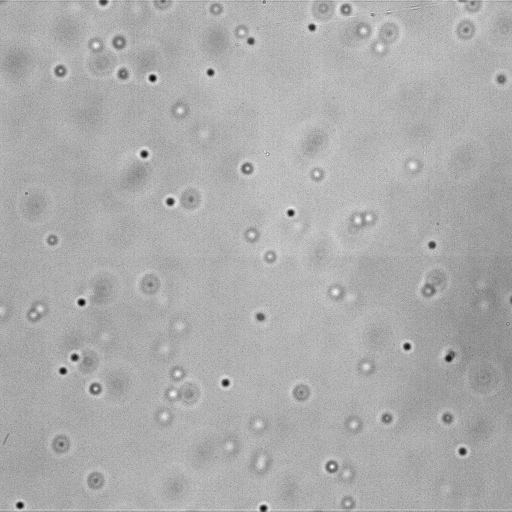

In [78]:
pims_video[2]

In [79]:
#Define simple video browser with ipywidgets

def browse_images_ptm(video):
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(6,6))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w


In [80]:
browse_images_ptm(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-interact',))

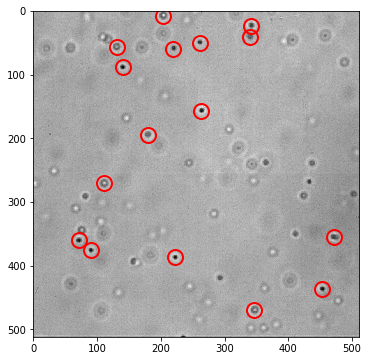

In [81]:
import trackpy as tp
fnum=100
pyplot.figure(figsize=(6,6))
fsingle = tp.locate(pims_video[fnum], 15, invert=True, minmass=1000)
tp.annotate(fsingle, pims_video[fnum])

In [82]:
f = tp.batch(pims_video, 15, minmass=1000, invert=True)

Frame 299: 12 features


In [83]:
pims_video.info['tracked']=f

In [84]:
def browse_images_tracked(video):
    frames=len(video)
    f=video.info['tracked']
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(8,8))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.plot(f.x[f.frame==framenum],f.y[f.frame==framenum],'o')
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w

In [85]:
browse_images_tracked(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-interact',))

In [86]:
t = tp.link_df(f, 5, memory=3)

Frame 299: 12 trajectories present.


In [87]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,28.469664,311.026616,1146.375086,2.515911,0.035747,41.693258,20237.0,-1.421232,0,0
17,468.716586,332.114238,1259.136398,4.777972,0.102901,17.814392,21489.0,0.167593,0,1
16,415.926465,385.553937,1054.081374,4.383290,0.003760,16.866818,21155.0,0.238816,0,2
15,379.243692,224.376599,1096.532691,2.743972,0.044974,30.890914,20396.0,6.968164,0,3
14,369.852104,62.356948,1251.934836,2.429104,0.071772,48.326277,20621.0,0.745006,0,4


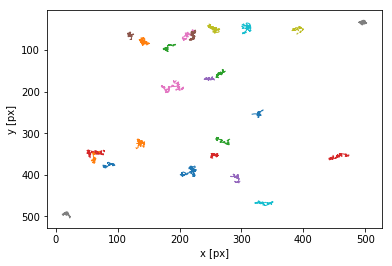

In [88]:
t1 = tp.filter_stubs(t, 50)
tp.plot_traj(t1)

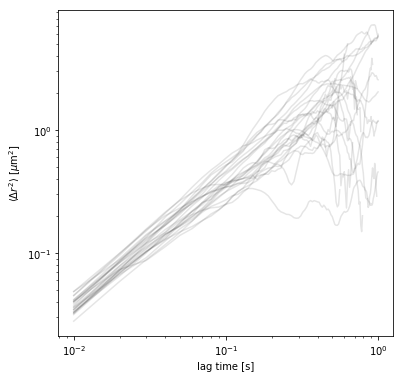

In [89]:
im = tp.imsd(t1, pims_video.info['muperpix'], pims_video.info['interval']**-1)
im.plot(loglog=True, style='k-', alpha=0.1, legend=False, figsize=(6,6))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');

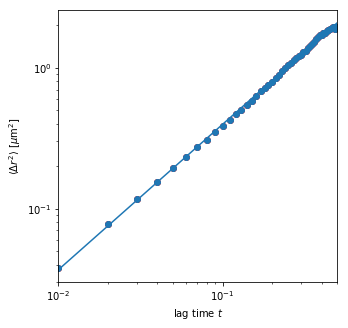

,n,A
msd,1.032386,4.278385


In [90]:
em = tp.emsd(t, pims_video.info['muperpix'], pims_video.info['interval']**-1,max_lagtime=50)
em.plot(loglog=True, style='ro', figsize=(5,5))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
pyplot.xlabel('lag time $t$')

result=tp.utils.fit_powerlaw(em)
result

For Newtonian liquids:
* $n=1$
* $A=4D$, where $D$ is the particles’ diffusivity.

$D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as:
$$D=\frac{kT}{6 \pi \eta a}$$

In [91]:
kb=1.380E-23
tempK=273+pims_video.info['temperature']

float(kb*tempK*4/(6*3.14*result.A*1e-12*pims_video.info['tracer_radius']))

0.0010203862418761702

# Same video analyzed with DDM (Differential Dynamic Microscopy)

In [103]:
from pylab import *
from numpy import *
import scipy

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed

def browse_images_FFT(video):
    
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum,delta):
        figure(figsize=(12,8))
        
        im1=video[framenum].astype(np.float)
        im2=video[framenum+delta].astype(np.float)
        imdiff=im2-im1

        F1=scipy.fftpack.fft2(imdiff)
        F2 = scipy.fftpack.fftshift( F1 )
        psd2D = np.abs( F2 )**2
        psd1D = azimuthalAverage(psd2D)
        
        
        subplot(2,3,1)
        title('(a) image 1 $I(r,t)$, time: ' + str(framenum*interval) + ' s')
        imshow( im1)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,2)
        title('(b) image 2 $I(r,t+ \Delta t)$, time: ' + str((framenum+delta)*interval) + ' s')
        imshow( im2)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,3)
        title('(c) image2-image1, delta t:'+ str((delta)*interval) +
              ' s\n $I( q ,t+ \Delta t ) - I(q,t)$')
        imshow( imdiff)
        set_cmap('gray')
        axis('off')
        
        subplot(2,3,4)
        title('(d)FFT - $g(q,t)$ ')
        imshow( np.log10( psd2D ))
        subplot(2,3,5)
        plot( psd1D )
        yscale('log')
    
        xlabel('Spatial Frequency')
        ylabel('Power Spectrum')
        subplot(2,3,6)
        plot( psd1D )
        xscale('log')
        yscale('log')
        xlabel('Spatial Frequency')
        ylabel('Power Spectrum')

        
    w=interactive(view_image, framenum=(0,frames),delta=(1,frames-100))
    return w

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof



In [104]:
DDM_step1=browse_images_FFT(pims_video)
display(DDM_step1)

interactive(children=(IntSlider(value=150, description='framenum', max=300), IntSlider(value=100, description='delta', max=200, min=1), Output()), _dom_classes=('widget-interact',))

In [106]:
dbcollection=conn.microrheology.fs.files
dbdoc=dbcollection.find_one(video._id)


In [107]:
def iq_delta(totalframes,video,delta):
    iq=[]
    
    counter=0
    for frame in range(totalframes-delta):
        
        im1=video[frame].astype(np.float)
        im2=video[frame+delta].astype(np.float)
        imdiff=im2-im1

        F1=fftpack.fft2(imdiff)
        F2 = fftpack.fftshift( F1 )
        psd2D = np.abs( F2 )**2
        psd1D = azimuthalAverage(psd2D)
        iq.append(psd1D)
        
    return(mean(iq,0))
def iq_delta_multi(totalframes,video,deltalist):
    iq=[]
    
    for delta in deltalist:
        result=iq_delta(totalframes,video,delta)
        iq.append(result)
    return array(iq)
    
def decay(x, a, b,c):
    
    return a*(1-exp(-b*x))+c
def explore_iq_dt(video):
    
    frames=len(video)
    frame_len=shape(video[0])[0]
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    result=pd.read_json(video.info['result_FFT'])
    xax=result.columns
    result=result[sort(list(xax))]
    deltalistsec=result.index
    iq2=result.values
    xax=result.columns
    
    def view_plot(selectq,deltat):
        figure(figsize=(15,3))
        
        gamma=[]
        
        subplot(1,3,1)
        plot(xax,iq2[deltat,:],'o')
        yscale('log')
        xscale('log')
        ylabel('I(q) [a.u.]')
        xlabel('q [um-1]')
        axvline(xax[selectq], color='k', linestyle='--')
        title(r'I(q) fixed $\Delta t$')
        
        
        subplot(1,3,2)
        plot(deltalistsec,iq2[:,selectq],'o')
        xscale('log')
        yscale('log')
        ylabel('g(q,dt) [a.u]')
        xlabel('Delta t [s]')

        x0=[1e9,2,1e9]
        fitpar=optimization.curve_fit(decay, deltalistsec[1:], iq2[1:,selectq], x0)
        gamma.append(fitpar[0][1])
        
        plot(logspace(-3,2),decay(logspace(-3,2),fitpar[0][0],fitpar[0][1],fitpar[0][2]))
        axvline(deltat*interval, color='k', linestyle='--')
        
        subplot(1,3,3)
        plot(deltalistsec,-(iq2[:,selectq]-(fitpar[0][2]+fitpar[0][0]))/fitpar[0][0],'o')
        plot(logspace(-3,2),exp(-fitpar[0][1]*logspace(-3,2)))
        axvline(deltat*interval, color='k', linestyle='--')
        xscale('log')
        ylabel('f(q,dt) [a.u.]')
        xlabel('Delta t')
            
        
        
    w=interactive(view_plot, selectq=(1,len(iq2[1,:]-1)),deltat=(1,len(deltalistsec)-1))
    return w
def get_viscosity(video,qmin,qmax):
    
    frames=len(video)
    frame_len=shape(video[0])[0]
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    radius=video.info['radius']
    
    result=pd.read_json(video.info['result_FFT'])
    xax=result.columns
    result=result[sort(list(xax))]
    deltalistsec=result.index
    iq2=result.values
    xax=result.columns
    
    gamma=[]

    for i in range(qmin,qmax):
        x0=[-1e9,2,1e8]
        fitpar=optimization.curve_fit(decay, deltalistsec[1:], iq2[1:,i], x0)
        gamma.append(fitpar[0][1])

    xax=array(range(qmin,qmax))*2*pi*pixpermu/frame_len
    
    def powerlaw(x, a):
        return a*x**2

    pl_fit=[]

    x0=[1]
    fitpar=optimization.curve_fit(powerlaw, xax, gamma, x0)
    fitpar[0]

    plot(xax,gamma,'o')
    plot(xax,powerlaw(xax,fitpar[0][0]))
    xscale('log')
    yscale('log')
    xlabel('q [um-1]')
    ylabel('Gamma [s-1]')
    
    Dm=fitpar[0]
    viscosity=1.3806488E-23 * 300 / (6*3.14*Dm*1e-6)/1e-12
    print(viscosity)

    
def preprocess_fft(DDM_collection,video):
    frames=len(video)
    interval=video['info']['interval']

    deltalist=unique(logspace(0, log10(frames-101), num=50, endpoint=True, base=10.0, dtype=int))
    deltalistsec=transpose(array(deltalist)*interval)

    iq2=iq_delta_multi(frames,video,deltalist)
    
    
    frame_len=512
    muperpix=video['info']['muperpix']
    pixpermu=1/muperpix
    xax=array(range(len(iq2[0,:])))*2*pi*pixpermu/frame_len
    
    filename=video['info']['filename']


    result=pd.DataFrame(iq2,index=deltalistsec, columns=xax)
    dict_res=result.to_json()

    video_obj=DDM_collection.find_one({'filename':filename})
    video_obj['result_FFT']=dict_res
    id_obj=video_obj['_id']
    dbcollection.update({'_id':id_obj}, {"$set": video_obj}, upsert=False)
    